**This Notebook product generates a predictive model of employee attrition, by applying a random forest algorithm to a human resources dataset**

Created by Dee Weinacht (c) 2023

---
# Data Preparation

## Initial Setup

First, necessary libraries and functionalities are imported:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

The dataset of human resources employee information is loaded into a pandas data frame:

In [2]:
# dataset sourced from kaggle: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset
employee_data = pd.read_csv('HR-Employee-Attrition.csv')

Now that the data is loaded, some features of the data can be explored:

In [3]:
employee_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [4]:
employee_data.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

The dataset includes **35 columns** of both numeric (26 variables) and categorical data (9 variables). There are **1470 entries** in total, and, significantly, **no null values** in the dataset - this is valuable, as the random forest algorithm cannot process null values and these missing values would need to be addressed.

## Data Cleaning

The first step of data cleaning will be to remove personally identifying information, as well as any variables that, if used to make predictions or business decisions, might be considered discriminatory.

In this case 'employee number', 'age', 'gender', and 'marital status' are dropped from the dataset.

In [5]:
employee_data.drop(['EmployeeNumber','Age','Gender','MaritalStatus'],axis=1,inplace=True)

Each of the remaining variables is examined to determine if any can be removed as having no predictive value.

Each variable is determined to be either numeric or categorical, then either the range of numbers or the categorical values are listed:

In [6]:
for attribute in employee_data.columns:
    print(attribute)
    if employee_data[attribute].dtype == object:
        print('Categorical.  Values: {}\n'.format(employee_data[attribute].unique()))
    else:
        print('Numeric.  Range: {} to {}\n'.format(employee_data[attribute].min(),employee_data[attribute].max()))

Attrition
Categorical.  Values: ['Yes' 'No']

BusinessTravel
Categorical.  Values: ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']

DailyRate
Numeric.  Range: 102 to 1499

Department
Categorical.  Values: ['Sales' 'Research & Development' 'Human Resources']

DistanceFromHome
Numeric.  Range: 1 to 29

Education
Numeric.  Range: 1 to 5

EducationField
Categorical.  Values: ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']

EmployeeCount
Numeric.  Range: 1 to 1

EnvironmentSatisfaction
Numeric.  Range: 1 to 4

HourlyRate
Numeric.  Range: 30 to 100

JobInvolvement
Numeric.  Range: 1 to 4

JobLevel
Numeric.  Range: 1 to 5

JobRole
Categorical.  Values: ['Sales Executive' 'Research Scientist' 'Laboratory Technician'
 'Manufacturing Director' 'Healthcare Representative' 'Manager'
 'Sales Representative' 'Research Director' 'Human Resources']

JobSatisfaction
Numeric.  Range: 1 to 4

MonthlyIncome
Numeric.  Range: 1009 to 19999

MonthlyRate
Numeric.  Rang

The variables 'employee count', 'over 18', and 'standard hours' have the same value for all employees and thus have no predictive value.

These variables are dropped from the dataset:

In [7]:
employee_data.drop(['EmployeeCount','Over18','StandardHours'],axis=1,inplace=True)

The top few rows of the reduced data set:

In [8]:
employee_data.head()

,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,HourlyRate,JobInvolvement,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,94,3,...,3,1,0,8,0,1,6,4,0,5
1,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,61,2,...,4,4,1,10,3,3,10,7,1,7
2,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,92,2,...,3,2,0,7,3,3,0,0,0,0
3,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,56,3,...,3,3,0,8,3,3,8,7,3,0
4,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,40,3,...,3,4,1,6,3,3,2,2,2,2


**After data cleaning there are 1470 entries, with 28 remaining variables**

## Exploratory Data Analysis

Now some exploratory visualizations of the data can begin, to provide a better understanding of the data and inform any futher data wrangling that should be done before the dataset is ready to be used by a machine learning algorithm.

**'Attrition' is the target variable** (the variable the model will be created to predict). A simple count plot of this variable:

<AxesSubplot:xlabel='Attrition', ylabel='count'>

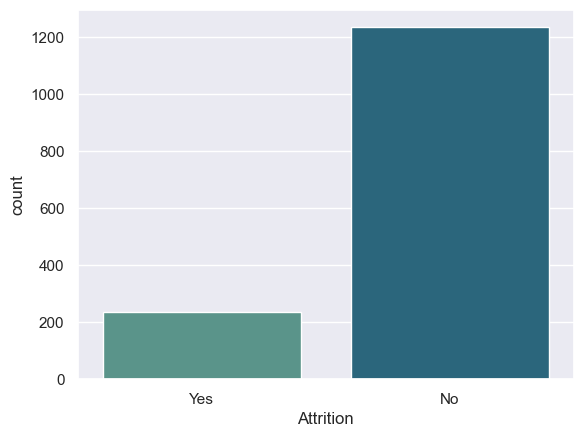

In [9]:
sns.set_theme() #sets the default seaborn theme
sns.countplot(data=employee_data,x='Attrition',palette='crest')

This graph shows that attrition is a boolean value, with a large disparity between the two predictive outcomes, meaning that this will be an **unbalanced binary classification** task.

While the other categorical variables will need to be converted to numeric later, it will be useful to convert attrition to a numeric boolean value now:

In [10]:
employee_data['Attrition'] = employee_data['Attrition'].apply(lambda val: 1 if val == 'Yes' else 0)

A visual inspection of correlations between the numeric variables:

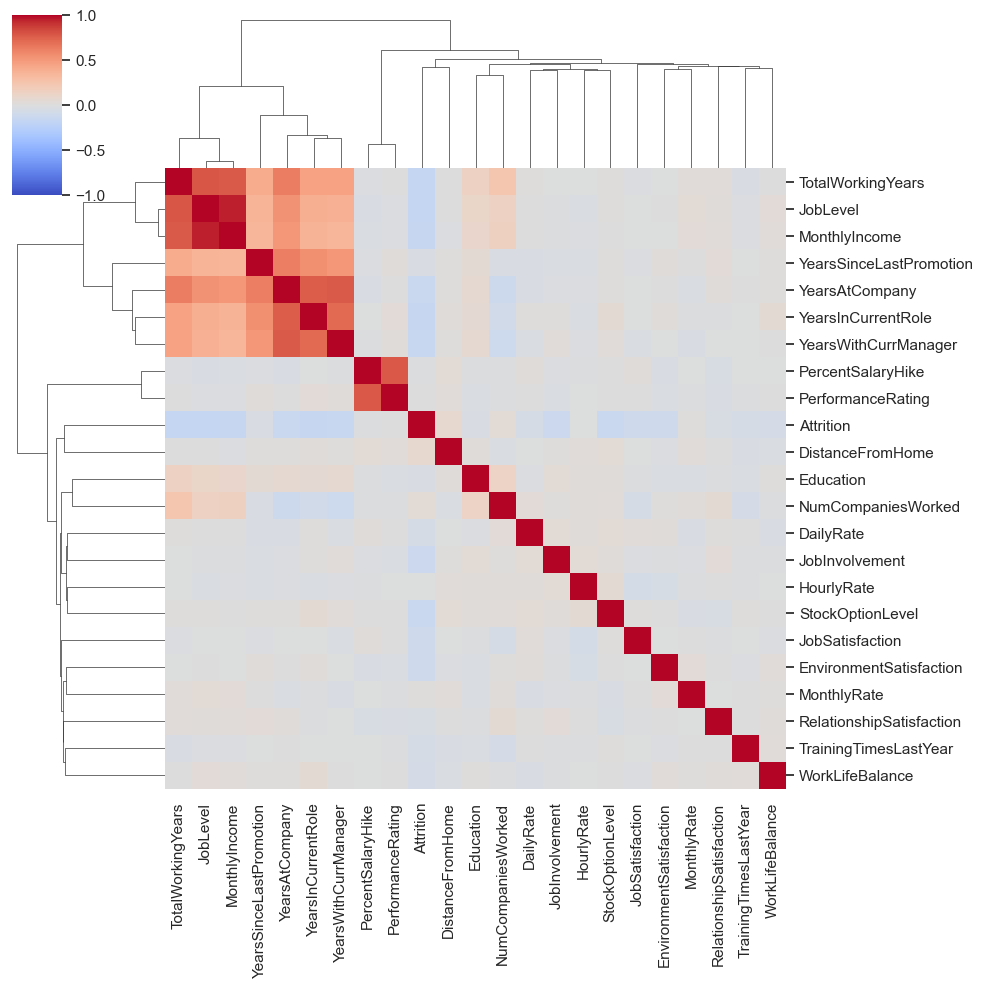

In [11]:
employee_data.corr()
sns.clustermap(data=employee_data.corr(),vmin=-1,cmap='coolwarm')

There are several clusters of correlation that become apparent from this graph, however, none of these correlations seem to be indicating that multiple variables are capturing the same information. Even though 'Job level' and 'monthly income' are particularly strongly correlated, there still may be predictive value in maintaining both variables as-is, so neither will be removed.

It is also important to investigate the correlations between these variables and the target variable. A graph of the correlations between the independent variables and the target variable, attrition:

<AxesSubplot:xlabel='Attrition', ylabel='index'>

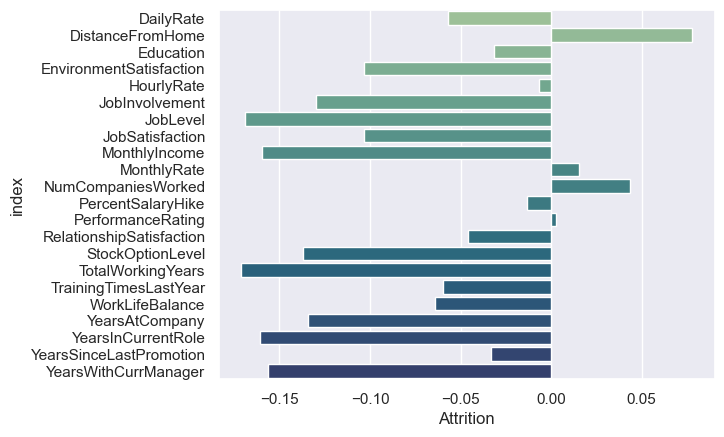

In [12]:
sns.barplot(data=employee_data.corr()['Attrition'][1:].reset_index(), x='Attrition',y='index',palette='crest')

From this graph, a **few very weakly positive correlations** are noted, in particular 'distance from home', which makes intuitive sense to be correlated with employee attrition.

There are also **many variables weakly negatively correlated to attrition**, including most of the cluster noted in the previous graph, other than 'years since last promotion', which, surprisingly, does not appear to be related to attrition likelihood.

There are also some categorical variables that have not been graphically examined yet. Of these, the 'business travel' variable appears to be a good candidate to relate to employee attrition. The following graph examines the 'business travel' variable:

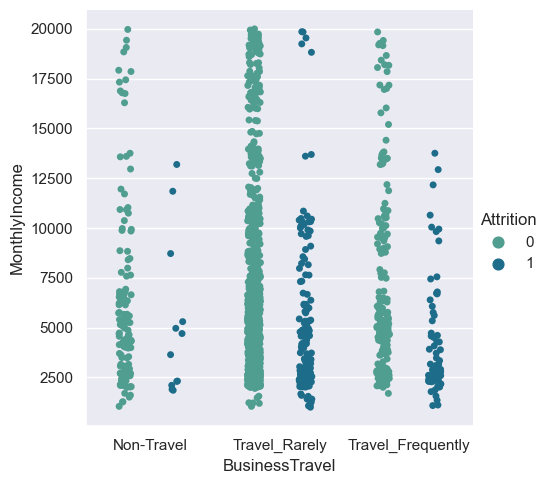

In [13]:
sns.catplot(data=employee_data,x='BusinessTravel',y='MonthlyIncome',hue='Attrition',order=['Non-Travel','Travel_Rarely','Travel_Frequently'],dodge=True,palette='crest')

This graph clearly shows the relationship between employee monthly income and attrition, but it seems like there is **no clear relationship between the amount of travel required of an employee and the attrition rate**.

## Data Wrangling

The dataset must be prepared for machine learning by converting the remaining categorical variables into a numeric form for use.

The following is a list of the categorical variables:

In [14]:
for attribute in employee_data.columns:
    if employee_data[attribute].dtype == object:
        print('{} : {}\n'.format(attribute,employee_data[attribute].unique()))

BusinessTravel : ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']

Department : ['Sales' 'Research & Development' 'Human Resources']

EducationField : ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']

JobRole : ['Sales Executive' 'Research Scientist' 'Laboratory Technician'
 'Manufacturing Director' 'Healthcare Representative' 'Manager'
 'Sales Representative' 'Research Director' 'Human Resources']

OverTime : ['Yes' 'No']



Of these categorical variables, we can see that **two are ordinal** - they have a ranking or ordering to the categories. 

We can therefore convert these columns, 'BusinessTravel' and 'OverTime', directly to numeric values:

In [15]:
employee_data['OverTime'] = employee_data['OverTime'].apply(lambda val: 1 if val == 'Yes' else 0)

In [16]:
def convert_travel(value):
    if value == 'Non-Travel':
        return 0
    elif value == 'Travel_Rarely':
        return 1
    else:
        return 2

In [17]:
employee_data['BusinessTravel'] = employee_data['BusinessTravel'].apply(convert_travel)

**The remaining categorical variables are nominal** - there is no ranking or ordering to the categories. 

These variables will be **converted to numeric values using dummy variables**:

In [18]:
employee_data_final = pd.get_dummies(data=employee_data,columns=['Department','EducationField','JobRole'],drop_first=True)

In [19]:
employee_data_final.to_csv('Machine-Learning-Employee-Attrition.csv',index=False) #save dataset as csv for future use
employee_data_final.describe()

,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,0.161224,1.086395,802.485714,9.192517,2.912925,2.721769,65.891156,2.729932,2.063946,2.728571,...,0.055782,0.089796,0.035374,0.176190,0.069388,0.098639,0.054422,0.198639,0.221769,0.056463
std,0.367863,0.532170,403.509100,8.106864,1.024165,1.093082,20.329428,0.711561,1.106940,1.102846,...,0.229579,0.285986,0.184786,0.381112,0.254199,0.298279,0.226925,0.399112,0.415578,0.230891
min,0.000000,0.000000,102.000000,1.000000,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,465.000000,2.000000,2.000000,2.000000,48.000000,2.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,802.000000,7.000000,3.000000,3.000000,66.000000,3.000000,2.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1157.000000,14.000000,4.000000,4.000000,83.750000,3.000000,3.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,2.000000,1499.000000,29.000000,5.000000,4.000000,100.000000,4.000000,5.000000,4.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**The dataset, now including 40 features, is ready for use in a machine learning algorithm**

---

# Machine Learning

## Separate Dataset into Training Data and Testing Data

The first step of machine learning is to separate the dataset into features and target, and then split the data into training and testing categories:

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X = employee_data_final.drop(columns = 'Attrition')
y = employee_data_final['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=36)

## Random Forest Model

The training data is used to generate a model with the default random forest algorithm:

In [22]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(random_state=36) #default hyper-parameters, other than random state, to ensure consistency
random_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=36)

The model is then used to generate predictions based on the testing portion of the dataset:

In [23]:
random_forest_predict = random_forest.predict(X_test)

Now the resulting model can be evaluated by comparing the predictions the model makes to the attrition test data.

This will be done in three ways: using a confusion matrix, a classification report, and a AUC-ROC score.

In [24]:
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score

Text(47.25, 0.5, 'Actual')

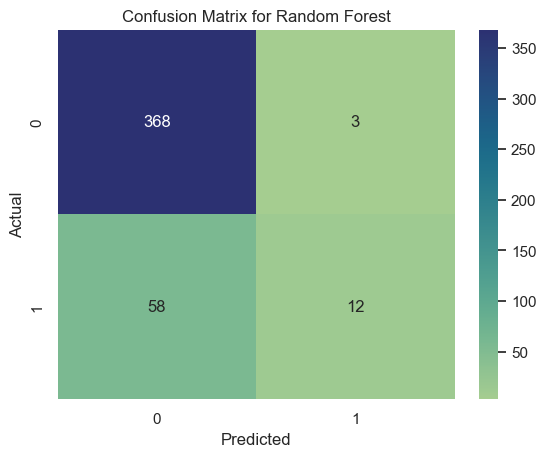

In [25]:
sns.heatmap(confusion_matrix(y_test, random_forest_predict),annot=True,cmap='crest',fmt='g')
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [26]:
print(classification_report(y_test,random_forest_predict))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       371
           1       0.80      0.17      0.28        70

    accuracy                           0.86       441
   macro avg       0.83      0.58      0.60       441
weighted avg       0.85      0.86      0.82       441



In [27]:
np.round(roc_auc_score(y_test,random_forest.predict_proba(X_test)[:, 1]),3)

0.825

From the confusion matrix and the classification report, the model is capturing almost all of the employees who are not in the attrition category (attrition = 0), but failing to capture most of the employees who are (12 out of 70 or 17%).

The area under the curve - receiver operating characteristic (AUC-ROC) is the standard that the model is being measured by, with a **0.825 AUC-ROC** exceeding our model accuracy goal. A 0.5 AUC-ROC is equivalent to random guessing.

The model could be improved by increasing the recall rate of employees who are in the attrition category (attrition = 1).

## Balanced Random Forest Model

A random forest model can also be generated with a classification weighting of the two prediction classes to attempt to counteract the class imbalance in the training data, this is called a balanced random forest.

A balanced random forest model is generated and predictions are made:

In [28]:
balanced_random_forest = RandomForestClassifier(class_weight='balanced',random_state=36)
balanced_random_forest.fit(X_train,y_train)
balanced_predict = balanced_random_forest.predict(X_test)

The predictive power of this balanced random forest model can now be evaluated, again using a confusion matrix, classification report, and a AUC-ROC score:

Text(47.25, 0.5, 'Actual')

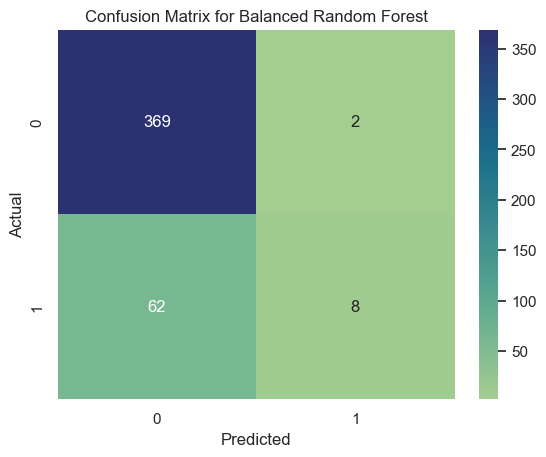

In [29]:
sns.heatmap(confusion_matrix(y_test, balanced_predict),annot=True,cmap='crest',fmt='g')
plt.title('Confusion Matrix for Balanced Random Forest')
plt.xlabel('Predicted')

plt.ylabel('Actual')

In [30]:
print(classification_report(y_test,balanced_predict))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       371
           1       0.80      0.11      0.20        70

    accuracy                           0.85       441
   macro avg       0.83      0.55      0.56       441
weighted avg       0.85      0.85      0.81       441



In [31]:
np.round(roc_auc_score(y_test,balanced_random_forest.predict_proba(X_test)[:, 1]),3)

0.79

Unfortunately using a balanced random forest lowered the recall of the positive attrition class, which was an unexpected and undesirable result. 

The balanced random forest algorithm resulted in a lower **ROC-AUC score of 0.79**, with no improvement to the generated model.

## Grid Search for Hyper Parameters

To optimize the hyper parameters of the random forest algorithm, we can run a grid search of multiple input values and compare the results. This evaluates all possible combinations of the possible parameters and then creates a model using the best ones found.

First, the 'grid' of different parameters to be tested is created:

In [32]:
from sklearn.model_selection import GridSearchCV
parameter_grid = {'max_features' : ['sqrt','log2',0.3],'n_estimators' : [10,100,1000],'class_weight' : [{0:1,1:1},{0:1,1:10},{0:1,1:100},{0:10,1:1}], 'max_depth' : [8,16,32,None], 'random_state' : [36]}

Evaluate all possible combinations of the possible parameters and generate a model with the best parameters:

<div class="alert alert-block alert-info">
    Note: Executing the grid search may take a substantial amount of time, depending on available processing capacity.
</div>

In [33]:
grid_search = GridSearchCV(RandomForestClassifier(), parameter_grid, n_jobs=-1, refit=True, verbose=0, scoring='roc_auc',)
grid_search.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 10},
                                          {0: 1, 1: 100}, {0: 10, 1: 1}],
                         'max_depth': [8, 16, 32, None],
                         'max_features': ['sqrt', 'log2', 0.3],
                         'n_estimators': [10, 100, 1000],
                         'random_state': [36]},
             scoring='roc_auc')

After comparing all 144 candidate models the following hyper parameters are deemed to result in the best AUC-ROC score:

In [34]:
print(grid_search.best_params_)

{'class_weight': {0: 1, 1: 1}, 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 1000, 'random_state': 36}


Predictions are made by the model created with these selected parameters. 

The results of these predictions are evaluated using a confusion matrix, classification report, and a AUC-ROC score:

In [35]:
grid_search_predict = grid_search.predict(X_test)

Text(47.25, 0.5, 'Actual')

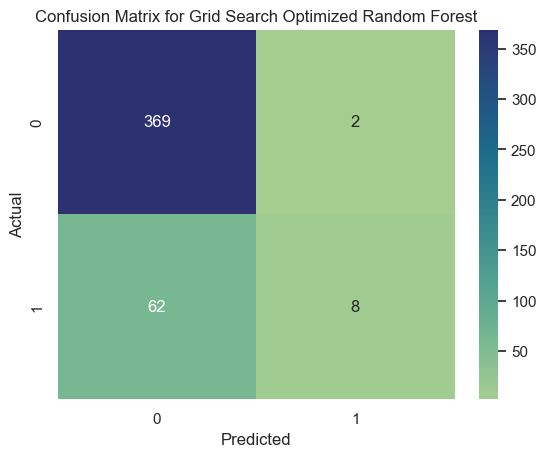

In [36]:
sns.heatmap(confusion_matrix(y_test, grid_search_predict),annot=True,cmap='crest',fmt='g')
plt.title('Confusion Matrix for Grid Search Optimized Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [37]:
print(classification_report(y_test,grid_search_predict))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       371
           1       0.80      0.11      0.20        70

    accuracy                           0.85       441
   macro avg       0.83      0.55      0.56       441
weighted avg       0.85      0.85      0.81       441



In [38]:
np.round(roc_auc_score(y_test,grid_search.predict_proba(X_test)[:, 1]),3)

0.817

This model has a **ROC-AUC score of 0.817**, meaning no improvement over the default hyperparameters. The grid search could not optimize the default random forest classifier futher. As a result, the default random forest classifier will be used as the predictive model.

---

# Application

## Feature Importance

One goal of the project is to identify which variables from the data set offer the most predictive power for employee attrition.

The list below is the top 10 most importance features to the predictive model:

In [39]:
feature_importance = pd.DataFrame(np.round(random_forest.feature_importances_,3),employee_data_final.columns[1:],columns=['Importance'])
feature_importance.sort_values('Importance',ascending=False)[:10]

,Importance
MonthlyIncome,0.089
MonthlyRate,0.061
DailyRate,0.055
TotalWorkingYears,0.052
DistanceFromHome,0.051
HourlyRate,0.050
OverTime,0.047
YearsAtCompany,0.043
PercentSalaryHike,0.040
StockOptionLevel,0.037


It appears that the employee **monthly income** variable is most significant to employee attrition, but not significantly so. As a result, employee attrition is best explained using a **combination of many factors**.

## Predictive Model Interactive Application

An interactive application is provided to allow user input of any combination of values to generate a prediction of employee attrition using the created model.

Imports for the GUI elements:

In [40]:
import ipywidgets as widgets
from IPython.display import display

A method that accepts input from the GUI, formats it for use in the model, then generates a prediction and displays the result:

In [41]:
def predict_attrition(button):
    attribute_list = [travel_widget.value, daily_rate_widget.value, department_widget.value, distance_widget.value, education_widget.value, field_widget.value, environment_widget.value, hourly_widget.value, involvement_widget.value, level_widget.value, title_widget.value,  satisfaction_widget.value, income_widget.value, monthly_widget.value, companies_widget.value, overtime_widget.value, raise_widget.value, rating_widget.value, relationship_widget.value, stock_widget.value, working_widget.value, training_widget.value, balance_widget.value, company_widget.value, role_widget.value, promotion_widget.value, manager_widget.value]
    input_data = pd.DataFrame(data=[attribute_list],columns=employee_data.drop(columns=['Attrition']).columns)
    input_data = pd.concat([input_data,employee_data.drop(columns=['Attrition'])])
    input_data = pd.get_dummies(data=input_data,columns=['Department','EducationField','JobRole'],drop_first=True)
    
    if random_forest.predict(input_data[:1])[0] == 0:
        print('This employee is predicted to stay with the company')
    else:
        print('This employee is predicted to leave the company' )
    return

Create the interactive elements:

In [42]:
travel_widget = widgets.Dropdown(options={'None': 0, 'Rarely': 1, 'Frequently': 2}, description='Travel:', style=dict(description_width='initial'), layout=dict(width='400px'))
daily_rate_widget = widgets.IntSlider(min=100, max=1500, description='Daily rate:', style=dict(description_width='initial'), layout=dict(width='400px'))
distance_widget = widgets.IntSlider(min=1, max=30, description='Distance from home:',style=dict(description_width='initial'), layout=dict(width='400px'))
education_widget = widgets.IntSlider(min=1, max=5, description='Level of education:', style=dict(description_width='initial'), layout=dict(width='400px'))
environment_widget = widgets.IntSlider(min=1, max=4, description='Work environment satisfaction:', style=dict(description_width='initial'), layout=dict(width='400px'))
hourly_widget = widgets.IntSlider(min=30, max=100, description='Employee hourly rate:', style=dict(description_width='initial'), layout=dict(width='400px'))
involvement_widget = widgets.IntSlider(min=1, max=4, description='Job involvement:', style=dict(description_width='initial'), layout=dict(width='400px'))
level_widget = widgets.IntSlider(min=1, max=5, description='Job level:', style=dict(description_width='initial'), layout=dict(width='400px'))
satisfaction_widget = widgets.IntSlider(min=1, max=4, description='Job satisfaction:', style=dict(description_width='initial'), layout=dict(width='400px'))
income_widget = widgets.IntSlider(min=1000, max=20000, description='Monthly income:', style=dict(description_width='initial'), layout=dict(width='400px'))
monthly_widget = widgets.IntSlider(min=2000, max=27000, description='Employee monthly rate:', style=dict(description_width='initial'), layout=dict(width='400px'))
companies_widget = widgets.IntSlider(min=0, max=10, description='Total companies worked:', style=dict(description_width='initial'), layout=dict(width='400px'))
overtime_widget = widgets.Dropdown(options={'No': 0, 'Yes': 1},description='Works overtime:', style=dict(description_width='initial'), layout=dict(width='400px'))
raise_widget = widgets.IntSlider(min=11, max=25, description='Last raise(percent):', style=dict(description_width='initial'), layout=dict(width='400px'))
rating_widget = widgets.IntSlider(min=1, max=4, description='Performance rating:', style=dict(description_width='initial'), layout=dict(width='400px'))
relationship_widget = widgets.IntSlider(min=1, max=4, description='Relationship satisfaction:', style=dict(description_width='initial'), layout=dict(width='400px'))
stock_widget = widgets.IntSlider(min=0, max=3, description='Stock option level:', style=dict(description_width='initial'), layout=dict(width='400px'))
working_widget = widgets.IntSlider(min=0, max=40, description='Total working years:', style=dict(description_width='initial'), layout=dict(width='400px'))
training_widget = widgets.IntSlider(min=0, max=6, description='Trainings last year:', style=dict(description_width='initial'), layout=dict(width='400px'))
balance_widget = widgets.IntSlider(min=1, max=4, description='Work-life balance:', style=dict(description_width='initial'), layout=dict(width='400px'))
company_widget = widgets.IntSlider(min=0, max=40, description='Years at company:', style=dict(description_width='initial'), layout=dict(width='400px'))
role_widget = widgets.IntSlider(min=0, max=18, description='Years in current role:', style=dict(description_width='initial'), layout=dict(width='400px'))
promotion_widget = widgets.IntSlider(min=0, max=15, description='Years since promotion:', style=dict(description_width='initial'), layout=dict(width='400px'))
manager_widget = widgets.IntSlider(min=0, max=17, description='Years with current manager:', style=dict(description_width='initial'), layout=dict(width='400px'))
department_widget = widgets.Dropdown(options=['Sales', 'Research & Development', 'Human Resources'],description='Department:', style=dict(description_width='initial'), layout=dict(width='400px'))
field_widget = widgets.Dropdown(options=['Life Sciences', 'Other', 'Medical', 'Marketing', 'Technical Degree', 'Human Resources'],description='Field:', style=dict(description_width='initial'), layout=dict(width='400px'))
title_widget = widgets.Dropdown(options=['Sales Executive', 'Research Scientist', 'Laboratory Technician', 'Manufacturing Director', 'Healthcare Representative', 'Manager', 'Sales Representative', 'Research Director', 'Human Resources'],description='Job title:', style=dict(description_width='initial'), layout=dict(width='400px'))
submit_button = widgets.Button(description = 'Predict!')
submit_button.on_click(predict_attrition)

Display the interactive elements:

To use the application, simply use the drop down menus and sliders to enter the desired values. Once all values are selected, press the predict button to generate a prediction from the model for employee attrition.

In [43]:
display(travel_widget, daily_rate_widget, distance_widget, education_widget, environment_widget, hourly_widget, involvement_widget, level_widget, satisfaction_widget, income_widget, monthly_widget, companies_widget, overtime_widget, raise_widget, rating_widget, relationship_widget, stock_widget, working_widget, training_widget, balance_widget, company_widget, role_widget, promotion_widget, manager_widget, department_widget, field_widget, title_widget,submit_button)

Dropdown(description='Travel:', layout=Layout(width='400px'), options={'None': 0, 'Rarely': 1, 'Frequently': 2…

IntSlider(value=100, description='Daily rate:', layout=Layout(width='400px'), max=1500, min=100, style=SliderS…

IntSlider(value=1, description='Distance from home:', layout=Layout(width='400px'), max=30, min=1, style=Slide…

IntSlider(value=1, description='Level of education:', layout=Layout(width='400px'), max=5, min=1, style=Slider…

IntSlider(value=1, description='Work environment satisfaction:', layout=Layout(width='400px'), max=4, min=1, s…

IntSlider(value=30, description='Employee hourly rate:', layout=Layout(width='400px'), min=30, style=SliderSty…

IntSlider(value=1, description='Job involvement:', layout=Layout(width='400px'), max=4, min=1, style=SliderSty…

IntSlider(value=1, description='Job level:', layout=Layout(width='400px'), max=5, min=1, style=SliderStyle(des…

IntSlider(value=1, description='Job satisfaction:', layout=Layout(width='400px'), max=4, min=1, style=SliderSt…

IntSlider(value=1000, description='Monthly income:', layout=Layout(width='400px'), max=20000, min=1000, style=…

IntSlider(value=2000, description='Employee monthly rate:', layout=Layout(width='400px'), max=27000, min=2000,…

IntSlider(value=0, description='Total companies worked:', layout=Layout(width='400px'), max=10, style=SliderSt…

Dropdown(description='Works overtime:', layout=Layout(width='400px'), options={'No': 0, 'Yes': 1}, style=Descr…

IntSlider(value=11, description='Last raise(percent):', layout=Layout(width='400px'), max=25, min=11, style=Sl…

IntSlider(value=1, description='Performance rating:', layout=Layout(width='400px'), max=4, min=1, style=Slider…

IntSlider(value=1, description='Relationship satisfaction:', layout=Layout(width='400px'), max=4, min=1, style…

IntSlider(value=0, description='Stock option level:', layout=Layout(width='400px'), max=3, style=SliderStyle(d…

IntSlider(value=0, description='Total working years:', layout=Layout(width='400px'), max=40, style=SliderStyle…

IntSlider(value=0, description='Trainings last year:', layout=Layout(width='400px'), max=6, style=SliderStyle(…

IntSlider(value=1, description='Work-life balance:', layout=Layout(width='400px'), max=4, min=1, style=SliderS…

IntSlider(value=0, description='Years at company:', layout=Layout(width='400px'), max=40, style=SliderStyle(de…

IntSlider(value=0, description='Years in current role:', layout=Layout(width='400px'), max=18, style=SliderSty…

IntSlider(value=0, description='Years since promotion:', layout=Layout(width='400px'), max=15, style=SliderSty…

IntSlider(value=0, description='Years with current manager:', layout=Layout(width='400px'), max=17, style=Slid…

Dropdown(description='Department:', layout=Layout(width='400px'), options=('Sales', 'Research & Development', …

Dropdown(description='Field:', layout=Layout(width='400px'), options=('Life Sciences', 'Other', 'Medical', 'Ma…

Dropdown(description='Job title:', layout=Layout(width='400px'), options=('Sales Executive', 'Research Scienti…

Button(description='Predict!', style=ButtonStyle())

---
# Limitations and Further Improvements

The current model is limited by exclusion of some variables from the training data: the use of sensitive employee information, such as age, gender, etc. would most likely result in a more accurate model, but would mean the predictions generated could not be used as a basis for decisions regarding invidual employees.

The current model offers a reasonable AUC-ROC score, but improving precision of the attrition=1 class would be desireable. This could be attempted by changing the scoring of the grid parameter to reward precision, or using undersampling or oversampling techniques. 

Other possible improvements include reducing the total number of features could improve the model's performance. Using different machine learning algorithms or deep learning could also potentially result in an improved model.